In [3]:
import pickle 
import numpy as np 
import pandas as pd 
import pingouin as pg 
from scipy.special import softmax 

from IPython.display import clear_output
%matplotlib inline
%config InlineBackend.figure_format='retina'
from scipy.ndimage import gaussian_filter1d

import matplotlib.pyplot as plt 
import seaborn as sns 

import os
import sys
sys.path.append('..')
from utils.fit import fit_bms
from utils.viz import viz 
from utils.analyze import *
from utils.model import *
viz.get_style()
pth = os.path.abspath(os.getcwd())+'/..'

In [27]:
n = 20
fname = '../fits/syn_mos6_20-sub/fit_sub_info-FLR22-map.pkl'
with open(fname, 'rb')as handle: fit_sub_info = pickle.load(handle)

In [28]:
data = {'sub_id': [], 'alpha': [], 'type': [], 'trial_type': [], 'group': [], 'outcome': []}
for g in ['HC', 'PAT']:
    for i in range(n):
        p_lst = list(fit_sub_info[f'{g}{i+1}']['param_name'])
        p_names = ['α+_sta_gain', 'α__sta_gain', 
                    'α+_sta_loss', 'α__sta_loss',
                    'α+_vol_gain', 'α__vol_gain',
                    'α+_vol_loss', 'α__vol_loss']
        ind = [p_lst.index(p) for p in p_names]
        HC_param = fit_sub_info[f'{g}{i+1}']['param'].round(2)[ind]
        p = 1/(1+np.exp(-HC_param))
        data['sub_id'] += [f'{g}{i+1}']*8
        data['type']   += p_names
        data['alpha']  += p.tolist()
        data['group']  += [g]*8
        data['trial_type'] += ['sta']*4+['vol']*4
        data['outcome'] += ['gain', 'gain', 'loss', 'loss']*2
data = pd.DataFrame.from_dict(data)
data['log_alpha'] = data['alpha'].apply(lambda x: np.log(x))

## Learning curves

In [44]:
def get_a_remap(block_data):
    psi_type = block_data['psi_type'].unique()[0]
    if psi_type=='vol8-sta3':
        block1 = 1-block_data['a'].values[90:]
        block2 = 1-block_data['a'].values[:90]
    elif psi_type=='sta3-vol8':
        block1 = 1-block_data['a'].values[:90]
        block2 = 1-block_data['a'].values[90:]
    elif psi_type=='vol2-sta7': 
        block1 = block_data['a'].values[90:]
        block2 = block_data['a'].values[:90]
    elif psi_type=='sta7-vol2':
        block1 = block_data['a'].values[:90]
        block2 = block_data['a'].values[90:]
    a_remap = np.hstack([block1, block2])
    if block_data['feedback_type'].unique()[0]=='loss':
        a_remap = 1 - a_remap
    block_data['a_remap'] = a_remap
    block_data['trial']   = np.arange(0, 180)
    return block_data
def get_lr_curve(fit_sub_info, valid_sub_lst):
    data = []
    for sub_id, item in fit_sub_info.items():
        if sub_id in valid_sub_lst:
            for block_id, block_data in item.items():
                block_data = get_a_remap(block_data)
                data.append(block_data.copy())
    data = pd.concat(data, axis=0)
    psi  = np.zeros([180])
    psi[:90]     = .75
    psi[90:110]  = .2
    psi[110:130] = .8
    psi[130:150] = .2
    psi[150:170] = .8
    psi[170:180] = .2
    fig, ax = plt.subplots(1, 1, figsize=(7, 3))
    sel_data = data.groupby(by=['trial', 'group'])['a_remap'].mean().reset_index()
    smooth_data = {'a': [], 'group': [], 'trial': []}
    for g in ['HC', 'PAT']:
        smooth = gaussian_filter1d(sel_data.query(f'group=="{g}"')['a_remap'], sigma=2)
        n = smooth.shape[0]
        smooth_data['a'] += smooth.tolist()
        smooth_data['group'] += [g]*n
        smooth_data['trial'] += list(range(1, n+1))
    smooth_data = pd.DataFrame.from_dict(smooth_data)
    sns.lineplot(x='trial', y='a', data=smooth_data,
                hue='group', hue_order=['HC', 'PAT'], palette=viz.PurplePairs,
                lw=3.75,
                ax=ax)
    sns.lineplot(x=np.arange(180), y=psi, color='k', ls='--', lw=1.25, ax=ax, zorder=-10)
    ax.set_box_aspect(.3)
    ax.spines['left'].set_position(('axes',-0.03))
    ax.set_ylim([.1, .9])
    ax.set_yticks([.2, .4, .6, .8])
    ax.set_xticks([1, 45, 90, 135, 180])
    ax.set_ylabel('Probability')
    ax.set_xlabel('Trial')
    fig.tight_layout()


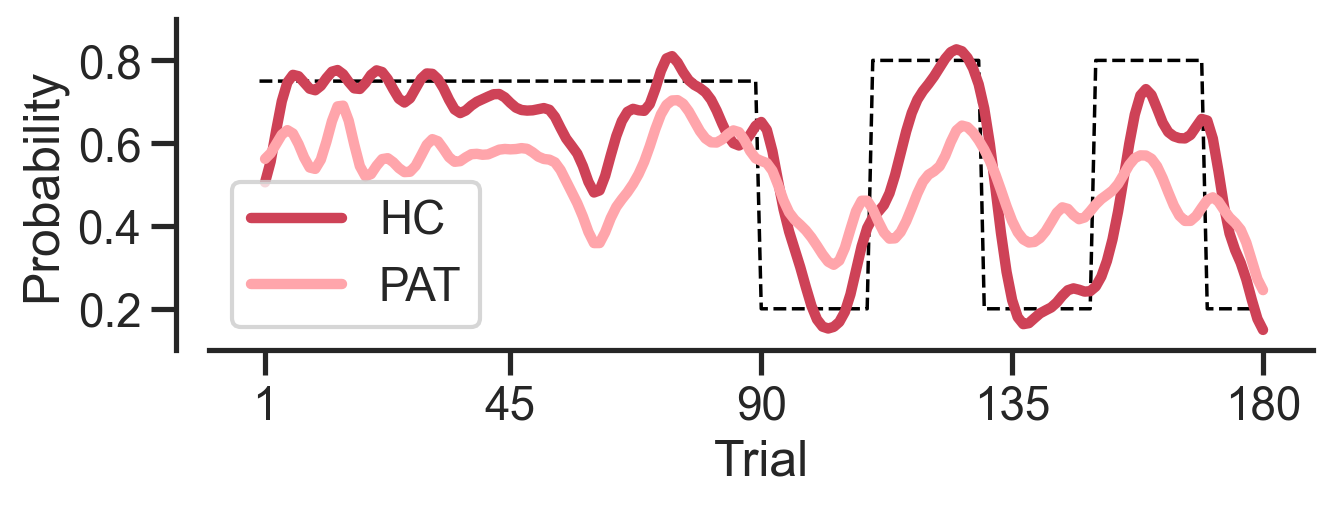

In [45]:
fname = '../data/syn_mos6_20-sub.pkl'
with open(fname, 'rb')as handle: fit_sub_info = pickle.load(handle)
valid_sub_lst = list(fit_sub_info.keys())
get_lr_curve(fit_sub_info, valid_sub_lst)
plt.savefig('../figures/Fig6A_learning_curves.pdf', dpi=300)


## log volatile learning rate > log stable learning rate  

In [29]:
tar = 'log_alpha'
sta_data = data.groupby(by=['sub_id', 'trial_type', 'group'])[tar].mean().loc[:, 'sta'].reset_index()
sta_data['trial_type'] = 'sta'
vol_data = data.groupby(by=['sub_id', 'trial_type', 'group'])[tar].mean().loc[:, 'vol'].reset_index()
vol_data['trial_type'] = 'vol'
t_test(sta_data[tar].values, vol_data[tar].values, paired=True)

 	t-paired(39.000)=-3.217, p=0.003, cohen-d=0.721


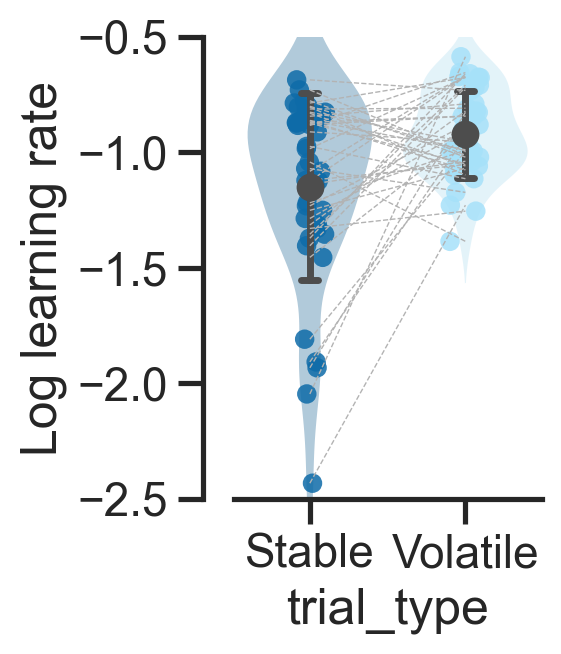

In [42]:
fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
x_var = 'trial_type'
x_order = ['sta', 'vol']
tar   = 'log_alpha'
viz_data = pd.concat([sta_data, vol_data], axis=0)
viz.violin(ax, data=viz_data, y=tar,
            x='trial_type', order=x_order,
            errorbar='sd', mean_marker_size=10,
            scatter_alpha=.85,
            palette=viz.BluePairs)
sub_lst = viz_data['sub_id'].unique()
for sub_id in sub_lst:
    y = []
    for t_type in ['sta', 'vol']:
        q = f'sub_id=="{sub_id}"&trial_type=="{t_type}"'
        y.append(viz_data.query(q)['log_alpha'].values[0])
    sns.lineplot(x=[0, 1], y=y, color=[.7]*3, ls='--', ax=ax, lw=.5)
ax.spines['left'].set_position(('axes',-0.1))
ax.set_box_aspect(1.5)
ax.set_xticks([0, 1])
ax.set_xticklabels(['Stable', 'Volatile'])
ax.set_ylabel('Log learning rate')
ax.set_ylim([-2.5, -.5])
plt.savefig('../figures/Fig6A_sta_vol.pdf', dpi=300)

## HC learning rate adaptation > PAT learning rate adaptation 

In [31]:
diff_data = sta_data.drop(columns=['trial_type']).merge(
            vol_data.drop(columns=['trial_type']), on=['sub_id', 'group'])
diff_data['adjust'] = diff_data.apply(
    lambda x: x['log_alpha_y'] - x['log_alpha_x']
, axis=1) 
x_data = diff_data.query('group=="HC"')['adjust']
y_data = diff_data.query('group=="PAT"')['adjust']
t_test(x_data, y_data)

 	t(38.000)=1.335, p=0.190, cohen-d=0.422


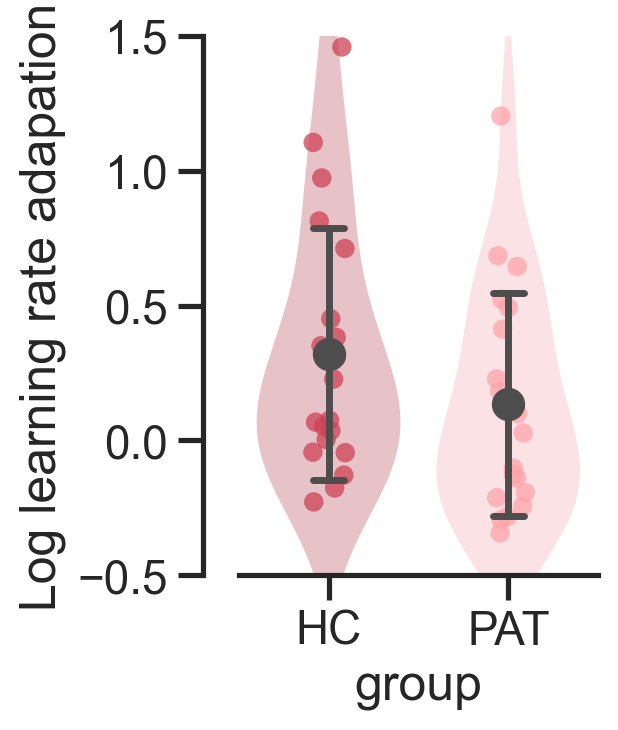

In [43]:
fig, ax = plt.subplots(1, 1, figsize=(3.5, 3.5))
x_var = 'group'
x_order = ['HC', 'PAT']
tar   = 'adjust'
viz_data = diff_data
viz.violin(ax, data=viz_data, y=tar,
            x='group', order=x_order,
            errorbar='sd', mean_marker_size=12,
            scatter_alpha=.75, err_capsize=.17,
            palette=viz.PurplePairs)
ax.spines['left'].set_position(('axes',-0.1))
ax.set_ylim([-.5, 1.5])
ax.set_box_aspect(1.5)
ax.set_ylabel('Log learning rate adapation')
plt.savefig('../figures/Fig6B_learning_rate_adapt.pdf', dpi=300)

## Learning curve 